<a href="https://colab.research.google.com/github/bir-damla/fish_classification/blob/main/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard

In [ ]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.15.0


In [ ]:
import tensorboard
tensorboard.__version__

'2.15.2'

In [ ]:
!rm -rf ./logs/

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = "/content/drive/My Drive/dataset/kaggle_big_data_set/Fish_Dataset"
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [ ]:
df.head()

,path,label
0,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
1,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
2,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
3,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
4,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9036 entries, 0 to 9035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9036 non-null   object
 1   label   9036 non-null   object
dtypes: object(2)
memory usage: 141.3+ KB


In [ ]:
df['label']=df['label'].astype('category')

In [ ]:
df['label'].value_counts()

label
Shrimp                1020
Striped Red Mullet    1010
Red Sea Bream         1004
Trout                 1002
Black Sea Sprat       1000
Red Mullet            1000
Hourse Mackerel       1000
Gilt-Head Bream       1000
Sea Bass              1000
Name: count, dtype: int64

# **Exploratory** **Data** **Analysis**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df['label'].unique()

['Black Sea Sprat', 'Gilt-Head Bream', 'Red Mullet', 'Hourse Mackerel', 'Sea Bass', 'Red Sea Bream', 'Shrimp', 'Trout', 'Striped Red Mullet']
Categories (9, object): ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', ...,
                         'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

In [ ]:
df

,path,label
0,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
1,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
2,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
3,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
4,/content/drive/My Drive/dataset/kaggle_big_dat...,Black Sea Sprat
...,...,...
9031,/content/drive/My Drive/dataset/kaggle_big_dat...,Striped Red Mullet
9032,/content/drive/My Drive/dataset/kaggle_big_dat...,Striped Red Mullet
9033,/content/drive/My Drive/dataset/kaggle_big_dat...,Striped Red Mullet
9034,/content/drive/My Drive/dataset/kaggle_big_dat...,Striped Red Mullet


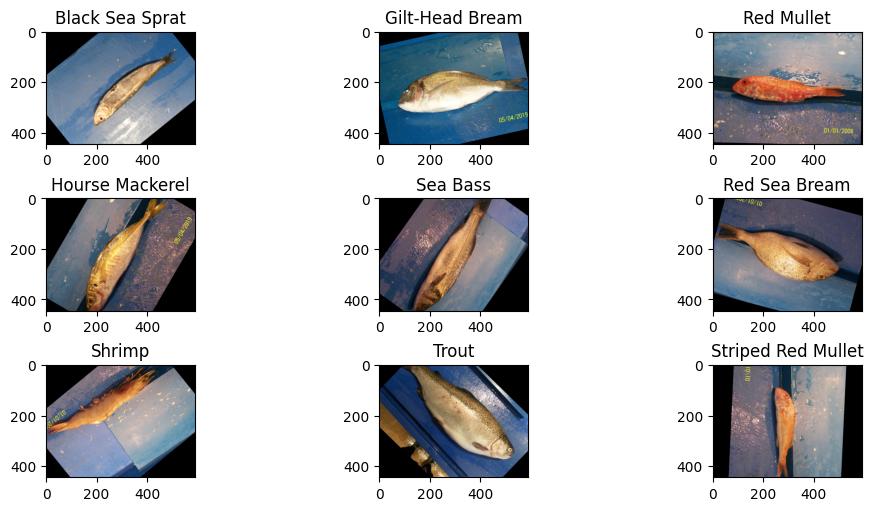

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['label'].unique():

    ax[j].imshow(plt.imread(df[df['label']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

<Axes: xlabel='count', ylabel='label'>

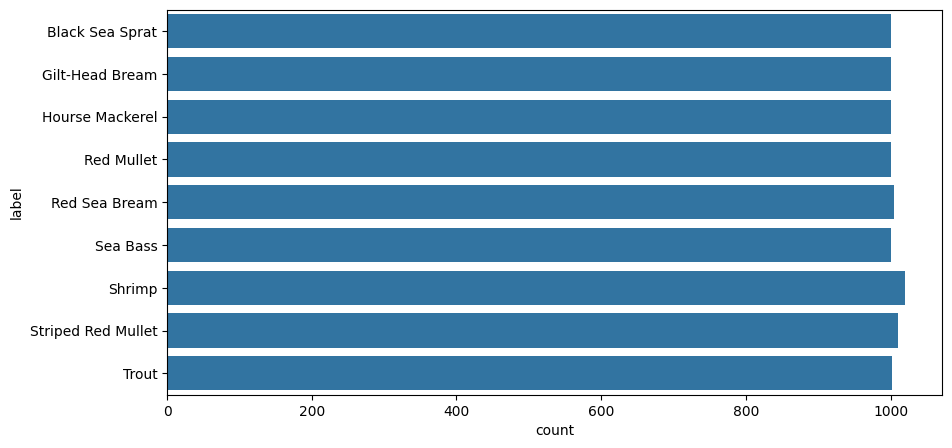

In [ ]:
fig=plt.figure(figsize=(10,5))
sns.countplot(df['label'])

# **Train Test split**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7228, 2)
(1808, 2)


## **Inception (GoogleNet)**

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3

trainGen_inception = ImageDataGenerator(preprocessing_function=preprocess_inception_v3_input, validation_split=0.3)
testGen_inception = ImageDataGenerator(preprocessing_function=preprocess_inception_v3_input)

X_train_img_inception = trainGen_inception.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',
                                                               class_mode='categorical', subset='training',
                                                               color_mode='rgb', batch_size=64)
X_val_img_inception = trainGen_inception.flow_from_dataframe(dataframe=X_train, x_col='path', y_col='label',
                                                             class_mode='categorical', subset='validation',
                                                             color_mode='rgb', batch_size=64)
X_test_img_inception = testGen_inception.flow_from_dataframe(dataframe=X_test, x_col='path', y_col='label',
                                                             class_mode='categorical', color_mode='rgb', batch_size=64,
                                                             shuffle=False)

Found 5060 validated image filenames belonging to 9 classes.
Found 2168 validated image filenames belonging to 9 classes.
Found 1808 validated image filenames belonging to 9 classes.


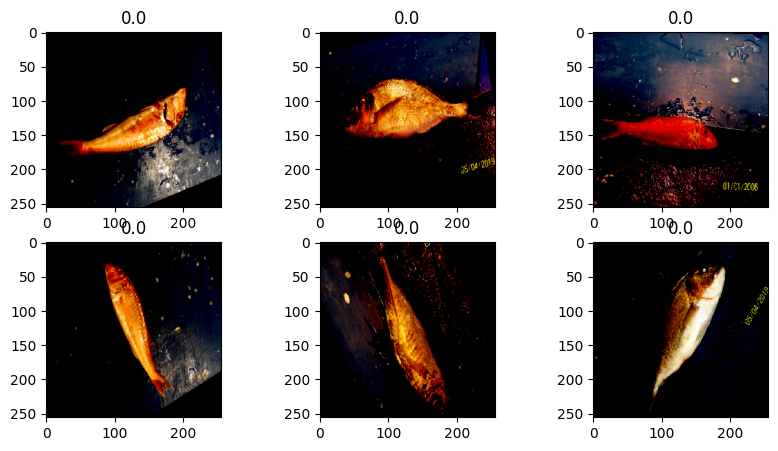

In [ ]:
fit_inception, ax_inception= plt.subplots(nrows=2, ncols=3, figsize=(10,5))
ax_inception=ax_inception.flatten()
j=0
for _ in range(6):
    img_inception, label_inception = X_test_img_inception.next()
    #print(img.shape)   #  (1,256,256,3)
    ax_inception[j].imshow(img_inception[0],)
    ax_inception[j].set_title(label_inception[0][0])
    #plt.show()
    j=j+1

In [ ]:
X_test_img_inception[0][0].shape

(64, 256, 256, 3)

In [ ]:
image_shape=(256,256,3)

In [ ]:
X_train_img_inception.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
X_val_img_inception.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
X_test_img_inception.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

pre_trained_inception = InceptionV3(include_top=False, pooling='avg', input_shape=image_shape)
pre_trained_inception.trainable = False

inp_model_inception = pre_trained_inception.input
x_inception = Dense(128, activation='relu')(pre_trained_inception.output)
x_inception = Dropout(0.5)(x_inception)
x_inception = Dense(128, activation='relu')(x_inception)
output_inception = Dense(9, activation='softmax')(x_inception)
model_inception = Model(inputs=inp_model_inception, outputs=output_inception)

model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=1)
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

results_inception = model_inception.fit(X_train_img_inception, epochs=30,
                                        validation_data=X_val_img_inception,
                                        callbacks=[early_stop, tensorboard_callback])

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
80/80 [==============================] - 1956s 25s/step - loss: 0.8698 - accuracy: 0.6966 - val_loss: 0.2004 - val_accuracy: 0.9479
Epoch 2/30
80/80 [==============================] - 116s 1s/step - loss: 0.2849 - accuracy: 0.9038 - val_loss: 0.1268 - val_accuracy: 0.9649
Epoch 3/30
80/80 [==============================] - 116s 1s/step - loss: 0.1877 - accuracy: 0.9354 - val_loss: 0.0670 - val_accuracy: 0.9811
Epoch 4/30
80/80 [==============================] - 117s 1s/step - loss: 0.1296 - accuracy: 0.9557 - val_loss: 0.0571 - val_accuracy: 0.9829
Epoch 5/30
80/80 [==============================] - 117s 1s/step - loss: 0.1015 - accuracy: 0.9664 - val_loss: 0.0399 - val_accuracy: 0.9894
Epoch 6/30
80/80 [==============================] - 117s 1s/step - loss: 0.0840 - accuracy: 0.9723 - val_loss: 0.0332 - val_accuracy: 0.9894
Epoch 7/30
80/80 [==============================] - 116s 1s/step - loss: 0.0899 - accur

In [ ]:
model_inception.save("google_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model Prediction**

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("google_model.h5")

In [ ]:
predictions_inception = loaded_model.predict(X_test_img_inception)
pred_inception=np.argmax(predictions_inception,axis=1)

29/29 [==============================] - 418s 15s/step


In [ ]:
pred_df_inception=X_test.copy()
labels={}
for l,v in X_test_img_inception.class_indices.items():
    labels.update({v:l})
pred_df_inception['pred']=pred_inception
pred_df_inception['pred']=pred_df_inception['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9939159292035398
F1 Score: 0.9939127453638825
                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      1.00       195
   Gilt-Head Bream       0.99      0.99      0.99       214
   Hourse Mackerel       1.00      0.98      0.99       199
        Red Mullet       1.00      0.99      1.00       187
     Red Sea Bream       0.99      1.00      0.99       201
          Sea Bass       1.00      0.98      0.99       202
            Shrimp       1.00      1.00      1.00       198
Striped Red Mullet       0.98      1.00      0.99       206
             Trout       1.00      1.00      1.00       206

          accuracy                           0.99      1808
         macro avg       0.99      0.99      0.99      1808
      weighted avg       0.99      0.99      0.99      1808



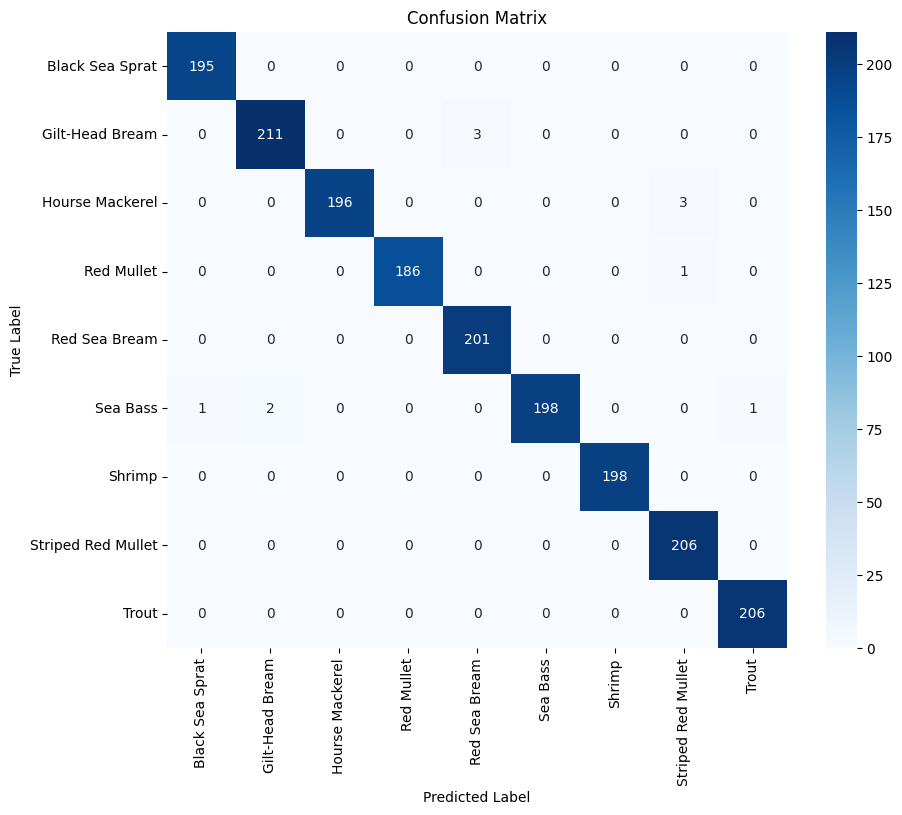

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

true_labels_inception = pred_df_inception['label']
pred_labels_inception = pred_df_inception['pred']

accuracy = accuracy_score(true_labels_inception, pred_labels_inception)
print(f"Accuracy Score: {accuracy}")

f1 = f1_score(true_labels_inception, pred_labels_inception, average='weighted')
print(f"F1 Score: {f1}")

print(classification_report(true_labels_inception, pred_labels_inception))

cm = confusion_matrix(true_labels_inception, pred_labels_inception)

le = LabelEncoder()

le.fit(true_labels_inception)

class_names = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

                                                   path               label  \
8645  /content/drive/My Drive/dataset/kaggle_big_dat...  Striped Red Mullet   
1318  /content/drive/My Drive/dataset/kaggle_big_dat...     Gilt-Head Bream   
4785  /content/drive/My Drive/dataset/kaggle_big_dat...            Sea Bass   
7538  /content/drive/My Drive/dataset/kaggle_big_dat...               Trout   
7682  /content/drive/My Drive/dataset/kaggle_big_dat...               Trout   
6192  /content/drive/My Drive/dataset/kaggle_big_dat...              Shrimp   

                    pred  
8645  Striped Red Mullet  
1318     Gilt-Head Bream  
4785            Sea Bass  
7538               Trout  
7682               Trout  
6192              Shrimp  


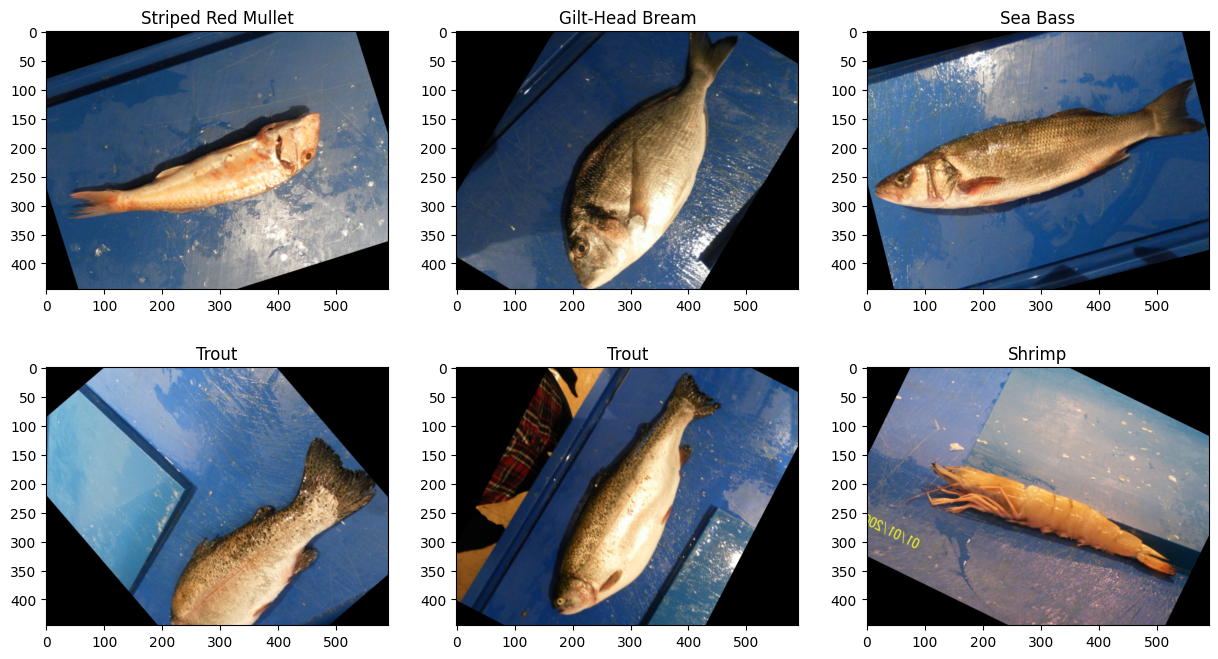

In [ ]:
print(pred_df_inception[pred_df_inception['label']==pred_df_inception['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df_inception[pred_df_inception['label']==pred_df_inception['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['path'][i]))
    ax[i].set_title(imlist['label'][i])